In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load labeled data
data = pd.read_csv('/content/flow_image_labeled_data.csv')

# Split into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Training pairs: {len(train_data)}, Testing pairs: {len(test_data)}")


Training pairs: 14264, Testing pairs: 3566


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import numpy as np

def preprocess_image(image_path, size=(224, 224)):
    # Load and preprocess an image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, size)
    img = img / 255.0  # Normalize
    return img

def data_generator(data, batch_size=32, size=(224, 224)):
    while True:
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            X1, X2, y = [], [], []
            for _, row in batch.iterrows():
                img1 = preprocess_image(row['Flow_Image1'], size)
                img2 = preprocess_image(row['Flow_Image2'], size)
                X1.append(img1)
                X2.append(img2)
                y.append(row['Label'])
            yield [np.array(X1), np.array(X2)], np.array(y)


In [4]:
import os
def preprocess_and_save(data, output_dir, size=(224, 224)):
    """
    Preprocesses image data and saves preprocessed arrays to output_dir.

    Args:
        data (pd.DataFrame): Input data containing 'Flow_Image1', 'Flow_Image2', and 'Label'.
        output_dir (str): Directory to save the processed data.
        size (tuple): Target image size for preprocessing.
    """
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    X1, X2, y = [], [], []
    for _, row in data.iterrows():
        img1 = preprocess_image(row['Flow_Image1'], size)
        img2 = preprocess_image(row['Flow_Image2'], size)
        X1.append(img1)
        X2.append(img2)
        y.append(row['Label'])

    # Save preprocessed data
    np.save(os.path.join(output_dir, "X1.npy"), np.array(X1))
    np.save(os.path.join(output_dir, "X2.npy"), np.array(X2))
    np.save(os.path.join(output_dir, "y.npy"), np.array(y))
    print(f"Saved preprocessed data to {output_dir}")

# Preprocess and save training and testing data
preprocess_and_save(train_data, "/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/train_data")
preprocess_and_save(test_data, "/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/test_data")

Saved preprocessed data to /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/train_data
Saved preprocessed data to /content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/test_data


In [2]:
import numpy as np

# Load preprocessed data
X1_train = np.load("/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/train_data/X1.npy")
X2_train = np.load("/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/train_data/X2.npy")
y_train = np.load("/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/train_data/y.npy")

X1_test = np.load("/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/test_data/X1.npy")
X2_test = np.load("/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/test_data/X2.npy")
y_test = np.load("/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/test_data/y.npy")

print(f"Training data loaded: {X1_train.shape}, Testing data loaded: {X1_test.shape}")


Training data loaded: (14264, 224, 224, 3), Testing data loaded: (3566, 224, 224, 3)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model

def build_siamese_model(input_shape):
    # Define the base network
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    model = Model(input, x)
    return model

# Input shape of flow images
input_shape = (224, 224, 3)

# Create the base network
base_network = build_siamese_model(input_shape)

# Define the two inputs
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Pass the inputs through the shared base network
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the distance between embeddings
distance = Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
output = Dense(1, activation='sigmoid')(distance)

# Create the Siamese model
siamese_model = Model([input_a, input_b], output)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(siamese_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  1293843   ['input_2[0][0]',             
                                                          2          'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 128)                  0         ['model[0][0]',         

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = siamese_model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_test, X2_test], y_test),
    batch_size=64,
    epochs=10,
    callbacks=[early_stopping]
)

siamese_model.save('/content/drive/MyDrive/VideoFramesWithConsecutiveFrames2/siamese_model.h5')
print("Model saved as siamese_model.h5")


Epoch 1/10
223/223 [==============================] - 285s 1s/step - loss: 0.0786 - accuracy: 0.9827 - val_loss: 0.1675 - val_accuracy: 0.9560
Epoch 2/10
223/223 [==============================] - 286s 1s/step - loss: 0.0471 - accuracy: 0.9925 - val_loss: 0.1867 - val_accuracy: 0.9602
Epoch 3/10
223/223 [==============================] - 286s 1s/step - loss: 0.0386 - accuracy: 0.9949 - val_loss: 0.1956 - val_accuracy: 0.9534
Epoch 4/10
223/223 [==============================] - 286s 1s/step - loss: 0.0360 - accuracy: 0.9971 - val_loss: 0.1802 - val_accuracy: 0.9551


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as siamese_model.h5


In [6]:
# Evaluate the model
test_loss, test_accuracy = siamese_model.evaluate([X1_test, X2_test], y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

112/112 [==============================] - 17s 154ms/step - loss: 0.1675 - accuracy: 0.9560
Test Loss: 0.1675, Test Accuracy: 0.9560


In [7]:
predictions = siamese_model.predict([X1_test, X2_test])
print(predictions[:10])  # Print similarity scores

112/112 [==============================] - 17s 153ms/step
[[8.8147432e-01]
 [9.7725236e-01]
 [9.9975657e-01]
 [9.8830247e-01]
 [9.9791676e-01]
 [9.7974938e-01]
 [5.5239205e-05]
 [9.5280379e-01]
 [9.4181126e-01]
 [9.7415102e-01]]


1. Analyze Prediction Outputs
The similarity scores (e.g., [0.88, 0.97, ...]) represent how similar the frame pairs are, as predicted by the model. Higher scores indicate higher similarity.

Suggestions:

Thresholding:
Determine a threshold (e.g., 0.8) for labeling pairs as match cuts.
Inspect High and Low Similarity Pairs:
Visualize a few pairs with the highest and lowest similarity scores to validate the model's predictions.

In [10]:
#Could do this too
threshold = 0.8
predicted_labels = [1 if score >= threshold else 0 for score in predictions]
print(predicted_labels[:10])

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


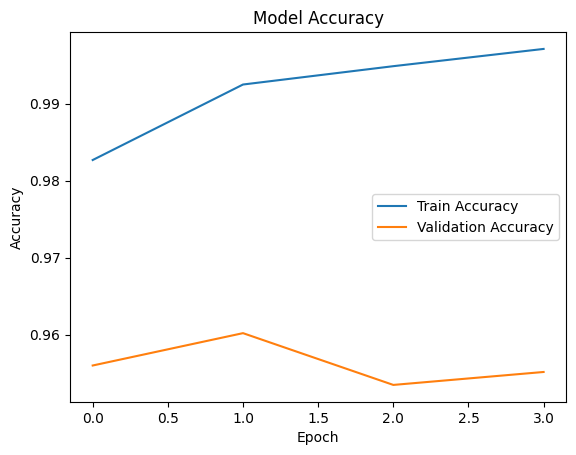

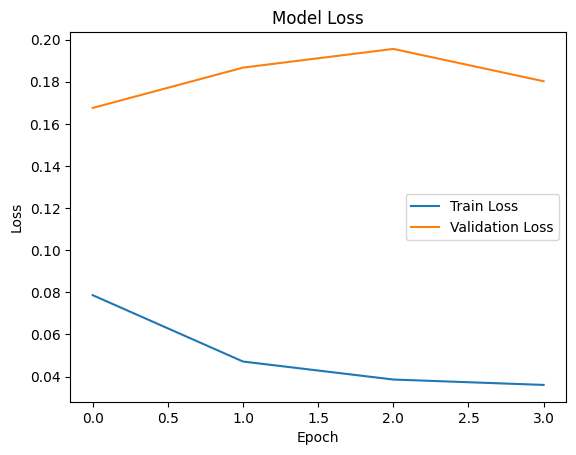

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


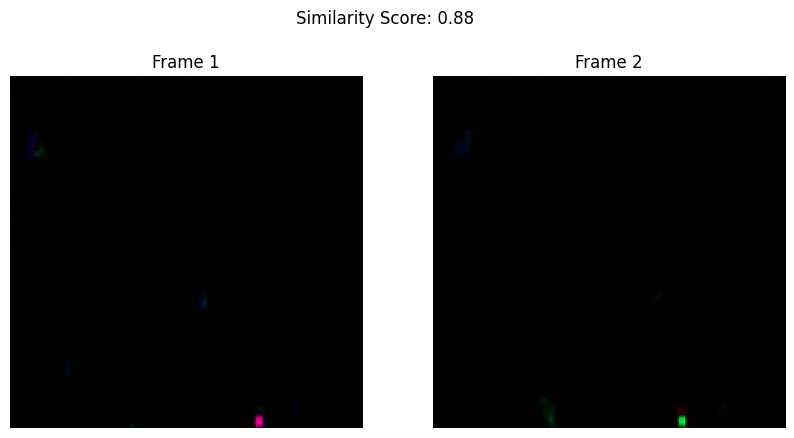

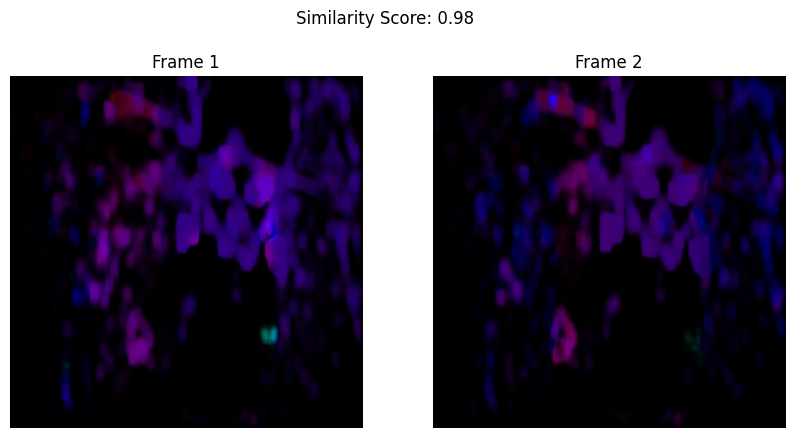

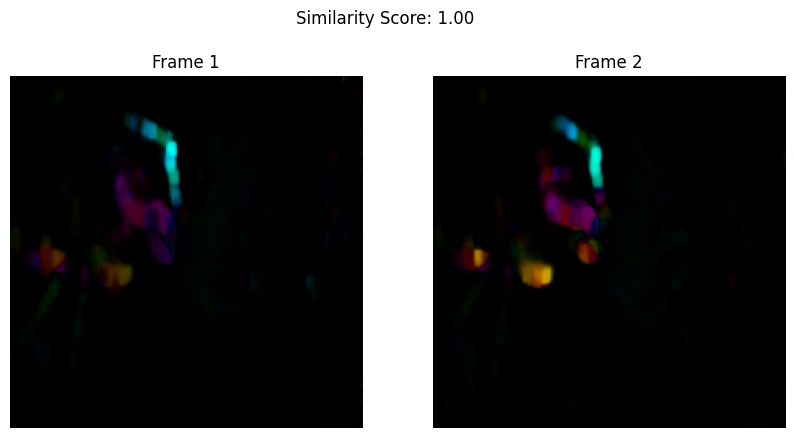

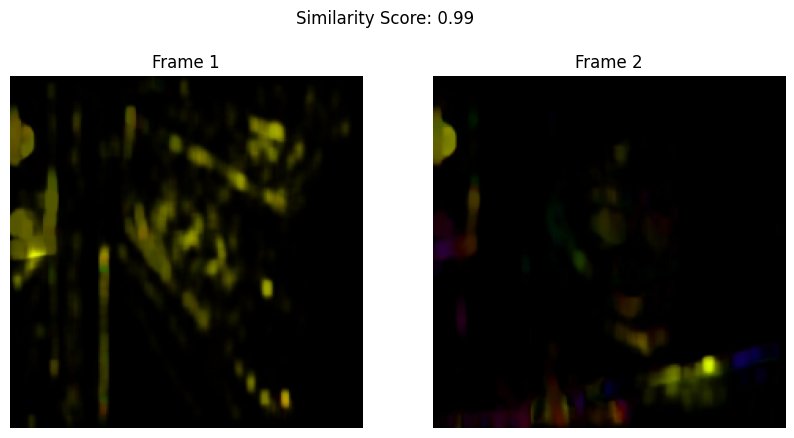

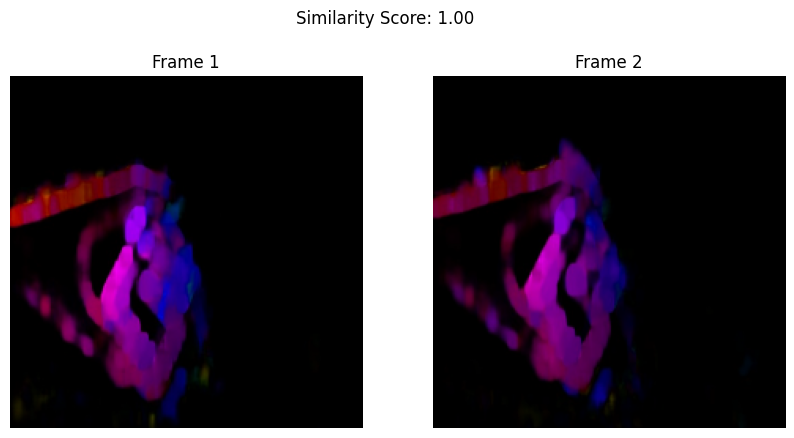

In [11]:
import matplotlib.pyplot as plt

def visualize_predictions(X1, X2, predictions, num_samples=5):
    for i in range(min(num_samples, len(predictions))):
        frame1 = X1[i]
        frame2 = X2[i]
        score = predictions[i][0]

        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Similarity Score: {score:.2f}")

        plt.subplot(1, 2, 1)
        plt.imshow(frame1)
        plt.title("Frame 1")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(frame2)
        plt.title("Frame 2")
        plt.axis("off")

        plt.show()

# Visualize the top 5 predictions
visualize_predictions(X1_test, X2_test, predictions, num_samples=5)
